# Classify dog and cat with a generic pre-trained encoder

This notebook present the following workflow
+ Load a pre-trained encoder (imagenet with 1000 classes)
+ Encode a bunch of images (transform them into 1k dimensional tensor)
+ Perform dimensionality reduction (100k -> 200 dimensions) with PCA (linear)
+ Do some KMEANS on PCA result to see what clusters arise
+ Reduce again the dimensionality with TSNE (200 -> 2) in a non linear way and get some insight

In [1]:
# Configure for retina display
%config InlineBackend.figure_format = 'retina'
# Full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)

In [3]:
Path.BASE_PATH = path

In [4]:
# take a look at data...
samples = (path/"images").ls()[:10]
for s in samples: print(s)

/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_22.jpg
/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_148.jpg
/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_83.jpg
/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_182.jpg
/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_185.jpg
/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_12.jpg
/root/.fastai/data/oxford-iiit-pet/images/havanese_126.jpg
/root/.fastai/data/oxford-iiit-pet/images/boxer_99.jpg
/root/.fastai/data/oxford-iiit-pet/images/keeshond_182.jpg
/root/.fastai/data/oxford-iiit-pet/images/keeshond_108.jpg


In [5]:
def get_breed(p):
    #return re.findall(r'(.+)_\d+.jpg$', p)
    return '_'.join((p.split('_'))[:-1])

list(map(lambda f:get_breed(f.name), samples))

['saint_bernard',
 'British_Shorthair',
 'Ragdoll',
 'great_pyrenees',
 'american_pit_bull_terrier',
 'wheaten_terrier',
 'havanese',
 'boxer',
 'keeshond',
 'keeshond']

In [6]:
def is_dog(f):
    # Capital means Cat
    c = f[0]
    capital = c==c.upper()
    return not capital

list(zip(
    map(lambda f:get_breed(f.name),samples), 
    map(lambda f:is_dog(f.name), samples)
))

[('saint_bernard', True),
 ('British_Shorthair', False),
 ('Ragdoll', False),
 ('great_pyrenees', True),
 ('american_pit_bull_terrier', True),
 ('wheaten_terrier', True),
 ('havanese', True),
 ('boxer', True),
 ('keeshond', True),
 ('keeshond', True)]

In [7]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(get_breed, 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


### Checking and Debugging a DataBlock

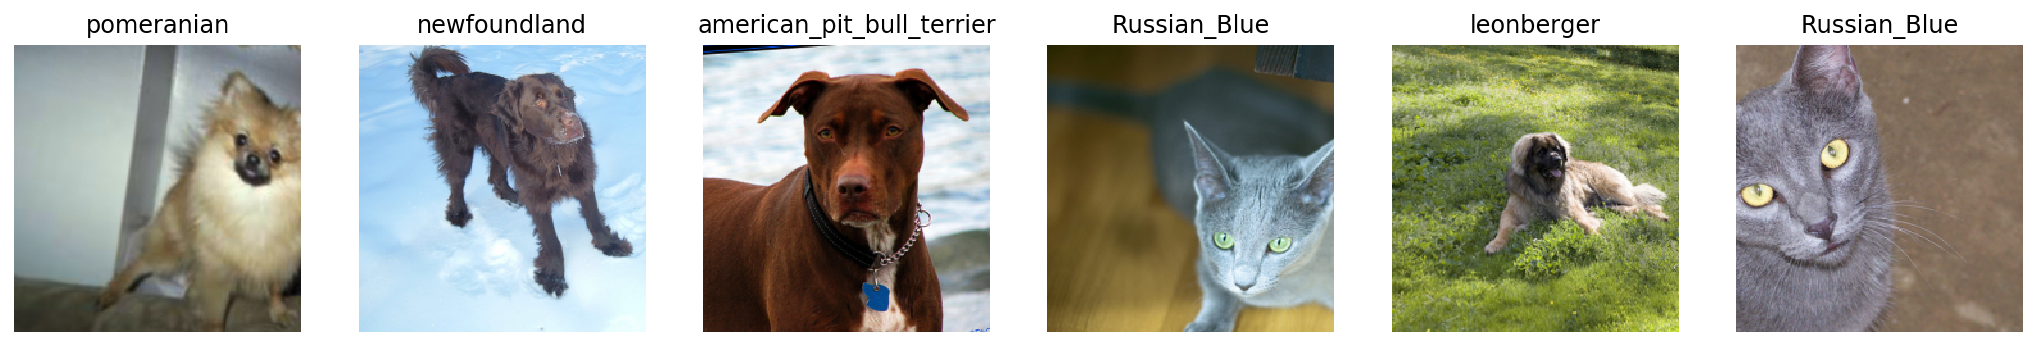

In [8]:
dls.show_batch(nrows=1, ncols=6)

In [9]:
# SAMPLE BATCH
b = dls.valid.one_batch()
bx,by = b
print('bx.shape: ',bx.shape)
print('by.shape: ',by.shape)

bx.shape:  torch.Size([64, 3, 224, 224])
by.shape:  torch.Size([64])


In [10]:
# Take a look at original resnet block (use the 18 version because it's esasier to explin)
resnet18(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In the end of the model we have AdaptiveAveragePool2d (fully convolutional thing) and the fully fonnected Linear layer that preditcs 1k classes.

In [11]:
# No final classification layer: get rid of the Linear layer that predicts with 1k classes
# This is the same as chopping out the last two layers:
#  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
#  (fc): Linear(in_features=512, out_features=1000, bias=True)
# And replace with
#  (1): Flatten()

number_of_channels = 3 # RGB input image
resnet_encoder = torch.nn.Sequential(
    create_body(resnet50, n_in=number_of_channels, pretrained=True, cut=None),
    torch.nn.Flatten()
)

In [12]:
# To cuda and freeze weight
resnet_encoder = resnet_encoder.cuda()
resnet_encoder.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [13]:
# The defauld pre-trained resnet encoder has 100k parameters
resnet_encoder(bx).shape

torch.Size([64, 100352])

## ENCODE ALLL THE SAMPLES IN VALIDATION SET

In [14]:
from tqdm import tqdm

In [15]:
def eval_all(model,dl):
    batches = L(dl) # TODO: use generator instead of list: batches = dl.cteate_batches(dl.sampler)
    retEnc = []
    retY = []
    for (bx,by) in tqdm(batches): 
        retEnc += [model(bx).detach().cpu()]
        retY += [by.detach().cpu()]
    return torch.cat(retEnc),torch.cat(retY) # Concat results, grabbing encoded and expected (y) 
    
es,ys = eval_all(resnet_encoder,dls.valid) # Test on the whole set
es.shape, ys.shape

100%|██████████| 24/24 [00:03<00:00,  6.34it/s]


(torch.Size([1478, 100352]), torch.Size([1478]))

In [16]:
# Convert types
es = np.array(es)
es.shape, es[:3]

((1478, 100352),
 array([[0.        , 0.        , 0.        , ..., 1.223228  , 0.6374248 ,
         0.22395486],
        [0.17342982, 0.19601056, 0.24036138, ..., 0.        , 0.        ,
         0.        ],
        [0.01615712, 0.        , 0.        , ..., 0.        , 0.54426897,
         0.48802274]], dtype=float32))

In [17]:
yl=[dls.vocab[x] for x in ys] 
yl[:3]

['basset_hound', 'shiba_inu', 'Russian_Blue']

## CREATE LABEL DF

In [18]:
ldf = pd.DataFrame(yl,columns=['Breed'])
ldf['Breed'] = ldf.Breed.astype('category')
ldf['Dog'] = ldf.Breed.apply(is_dog)
ldf

Breed    Dog
0           basset_hound   True
1              shiba_inu   True
2           Russian_Blue  False
3       scottish_terrier   True
4             Maine_Coon  False
...                  ...    ...
1473          Maine_Coon  False
1474          Abyssinian  False
1475  miniature_pinscher   True
1476             Ragdoll  False
1477        basset_hound   True

[1478 rows x 2 columns]

In [19]:
ldf.Dog.value_counts()

True     1015
False     463
Name: Dog, dtype: int64

## PCA

In [20]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [21]:
# TODO: Probably we don't need this - apparently no performance improvements
# Normalize data before PCA
#esn = preprocessing.normalize(es, copy=True, return_norm=False)
#esn.shape, esn[:,0].mean(), esn[:,0].std()
esn = es 

'pca output shape'

(1478, 200)

CPU times: user 12 s, sys: 1.88 s, total: 13.9 s
Wall time: 4.68 s


Text(0.5, 0, 'Number of PCA dimensions')

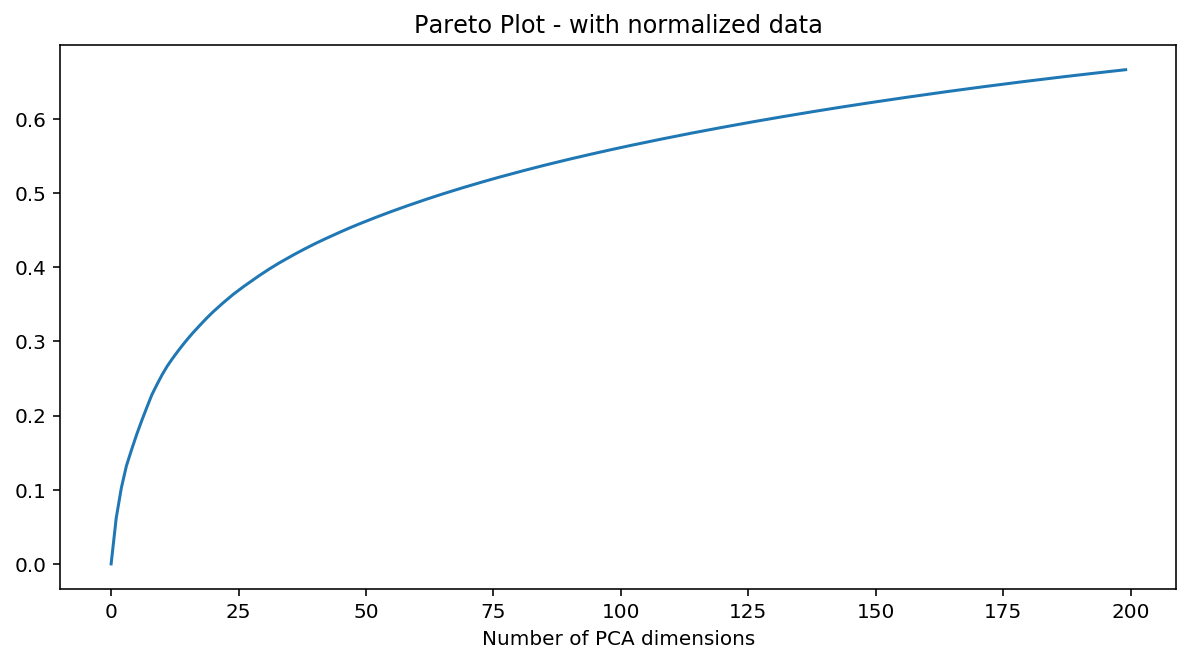

In [22]:
%%time
# Linearly reduce dimensionality with PCA
pca = PCA(n_components=200)
esp = pca.fit_transform(esn)
display('pca output shape',esp.shape)

# Simon insight!
plt.figure(figsize=(10,5))
plt.plot([pca.explained_variance_ratio_[:i].sum() for i,_ in enumerate(pca.explained_variance_ratio_)])
plt.title('Pareto Plot - with normalized data');
plt.xlabel('Number of PCA dimensions');

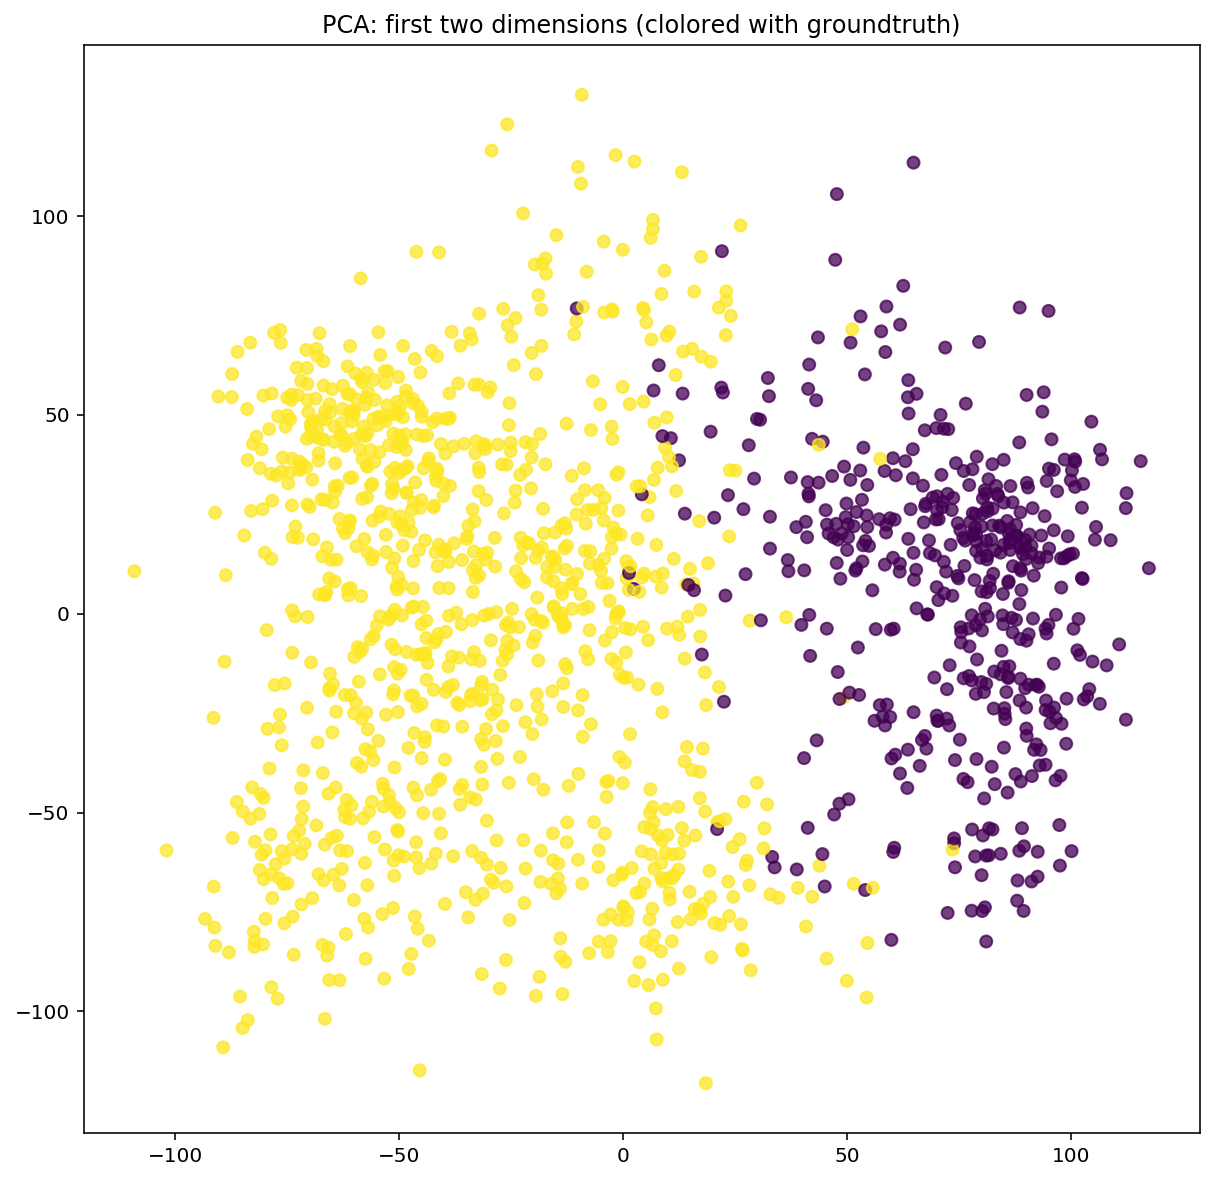

In [23]:
# NOTE: the PCA dimensions are ordered from the most iportant (holds more variation) to the less important 
plt.figure(figsize=(10,10))
plt.scatter(esp[:,0],esp[:,1],c=ldf.Dog.values, alpha=.75)
plt.title('PCA: first two dimensions (clolored with groundtruth)');

In [24]:
# Predtty print a sample of tensors after PCA dimensionality reduction
pd.DataFrame(esp[:10])

0          1          2           3          4          5    \
0 -48.531277  54.695179 -62.151787    9.493394 -26.805576  34.092392   
1 -15.189592  20.472431  90.788551  -10.817880   6.191034  62.406006   
2  94.154388  24.546780 -28.258434    9.100858  18.206345  12.957826   
3 -18.163263  16.672646  68.762260  114.014084  17.332140 -71.429832   
4  58.498356 -28.087673 -21.575544  -25.083519 -39.382965 -61.055462   
5 -60.679935 -48.181561 -32.300903    5.118540  16.214537  32.939831   
6 -52.955952 -25.383717 -30.513683   93.910599 -11.562309 -33.344585   
7  58.815487  77.254623  48.862068   52.137890 -18.172037  -8.775972   
8 -73.949501   0.873632 -66.232178   37.419765 -14.389176 -24.785761   
9  32.153339 -47.945805  41.973141   22.398886   4.683824  33.494396   

         6          7          8          9    ...        190       191  \
0  43.624256 -31.764387 -27.846851 -15.320349  ...  -2.917785 -0.243528   
1 -23.687109   7.343836 -50.471977  -1.755422  ... -10.131780 -9.732967   
2  -3.020193   9.413269  -3.807492 -17.779289  ...  -2.955954 -0.629912   
3 -21.332645  35.408825 -55.676006  -7.497590  ... -12.809191  3.990164   
4 -13.750422  12.151250 -10.756896 -16.155540  ...  -4.585700 -1.845384   
5 -52.593739 -45.382183  11.512609  37.942715  ...  -4.260485 -7.964733   
6  14.150144 -11.927896  -2.236957 -24.677170  ...  -9.665657  6.701829   
7  38.949554  57.223091  63.685524 -10.517385  ...  -9.655840 -3.395331   
8   0.108490 -29.952486  66.379486 -21.470242  ...  13.785482  6.449939   
9  32.472622   9.905056  -2.297712  -7.817113  ...   3.612850 -9.100080   

         192        193       194        195        196        197       198  \
0  -0.384544  11.581536 -3.723449  -2.620823   1.444506   3.785507  2.942802   
1   4.461813   4.445174  0.905979  13.461606 -10.924421   2.916201  9.873052   
2   2.522168   4.345769 -0.000446   1.269193  -6.650604   4.983047 -6.419057   
3  19.327383   1.879390  9.317714   1.191794   8.410029   2.249485  0.209953   
4  -3.064343   2.093607  2.321254   5.296178  -3.577325   9.554122 -4.591384   
5  -5.769315   0.535547 -4.381665   9.832525   9.921606  -0.956826 -4.325866   
6  -4.176784 -13.161706 -8.905915  -0.236629   5.580032   9.529488 -7.415046   
7  -3.334529  -6.814888 -2.755688   2.531417   7.269939  -7.012758  6.447803   
8  -2.812583  -1.627949  1.222318   9.367891  -2.358650 -11.004417  0.100633   
9  -9.701257  -5.273756  0.276175   8.542901  -6.652809  -2.228943 -1.529621   

         199  
0  13.190265  
1  -8.640971  
2   2.222535  
3  -7.350559  
4  -0.218155  
5  13.815785  
6 -11.219395  
7 -12.175924  
8  -2.511229  
9  -4.489277  

[10 rows x 200 columns]

## KMEANS ON PCA

We try to find two clusters (dog and cat) int the 1.5k rows of 200 dimensional embeddings.

In [25]:
from sklearn.cluster import KMeans

In [26]:
%%time
kmeans = KMeans(n_clusters=2, random_state=0).fit(esp) # Two clusters to distinguish dog and cats

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 204 ms


In [27]:
# See the performance
found = kmeans.labels_ # Prediction
actual = ldf.Dog.values # Groundtruth

In [28]:
found[:3], actual[:3]

(array([0, 0, 1], dtype=int32), array([True, True, False], dtype=object))

In [29]:
# IMPORTANT: the k means distinguish dog and cat, but don't know what's dog and cat, so we take the maximum
performance = (found==actual).sum()/len(found)
print('Accuracy:', max(performance, 1-performance))

Accuracy: 0.9756427604871448


In [30]:
1-performance

0.9756427604871448

**WOW AROUND 96% ACCURACY LEVERAGING A PRE-TRAINED MODEL**

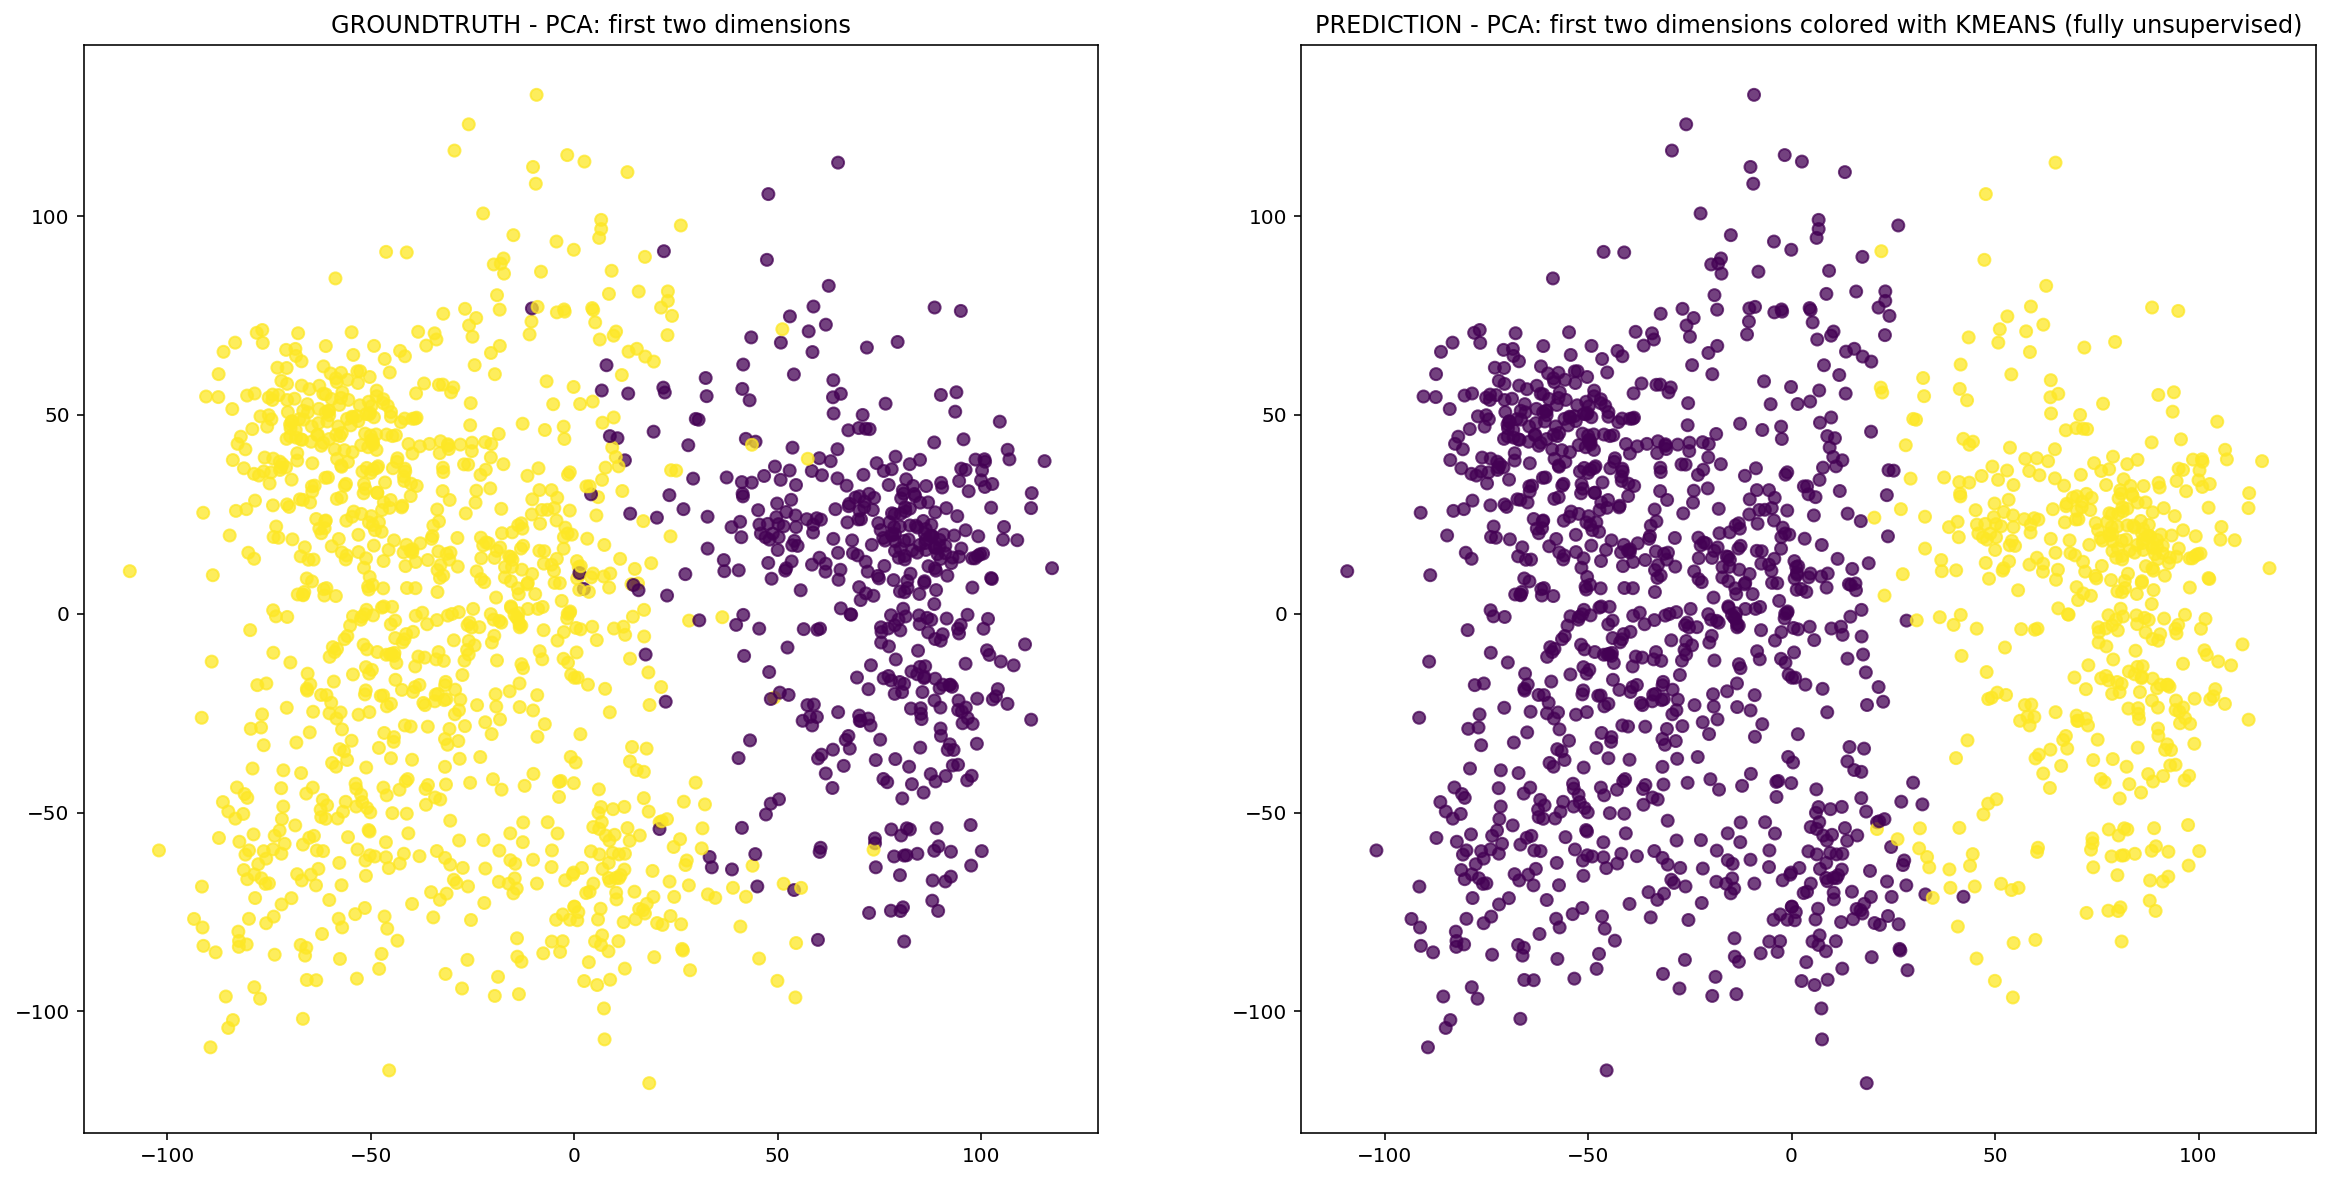

In [31]:
# NOTE: the PCA dimensions are ordered from the most iportant (holds more variation) to the less important 
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(esp[:,0],esp[:,1],c=ldf.Dog.values, alpha=.75)
plt.title('GROUNDTRUTH - PCA: first two dimensions')

plt.subplot(1,2,2)
plt.scatter(esp[:,0],esp[:,1],c=found, alpha=.75)
plt.title('PREDICTION - PCA: first two dimensions colored with KMEANS (fully unsupervised)');

## TSNE ON PCA

In [32]:
%%time
from sklearn.manifold import TSNE
est = TSNE(n_components=2).fit_transform(esp) # feed unnnormalized one...

CPU times: user 16 s, sys: 0 ns, total: 16 s
Wall time: 3.26 s


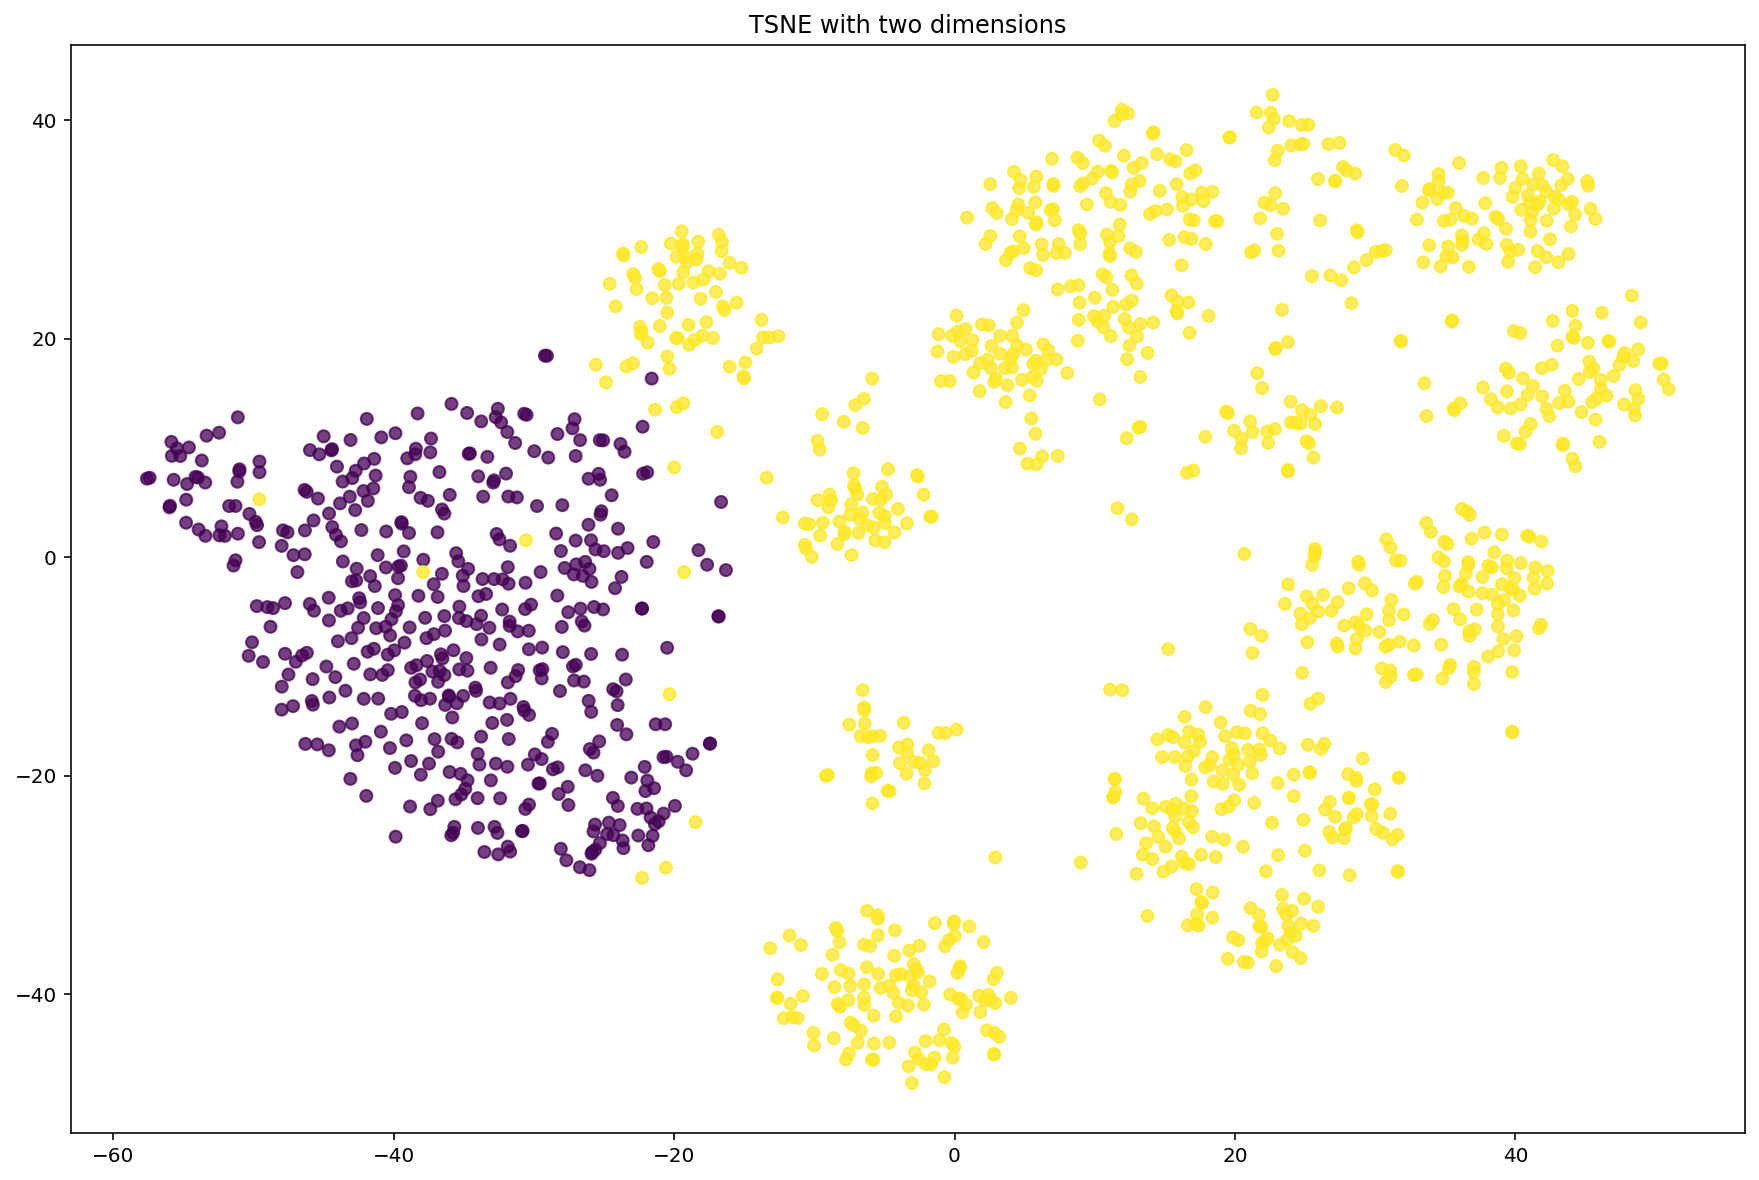

In [33]:
# Very good separation because of the strong non-linear nature of TSNE
plt.figure(figsize=(15,10))
plt.scatter(est[:,0],est[:,1],c=ldf.Dog.values, alpha=.75)
plt.title('TSNE with two dimensions');

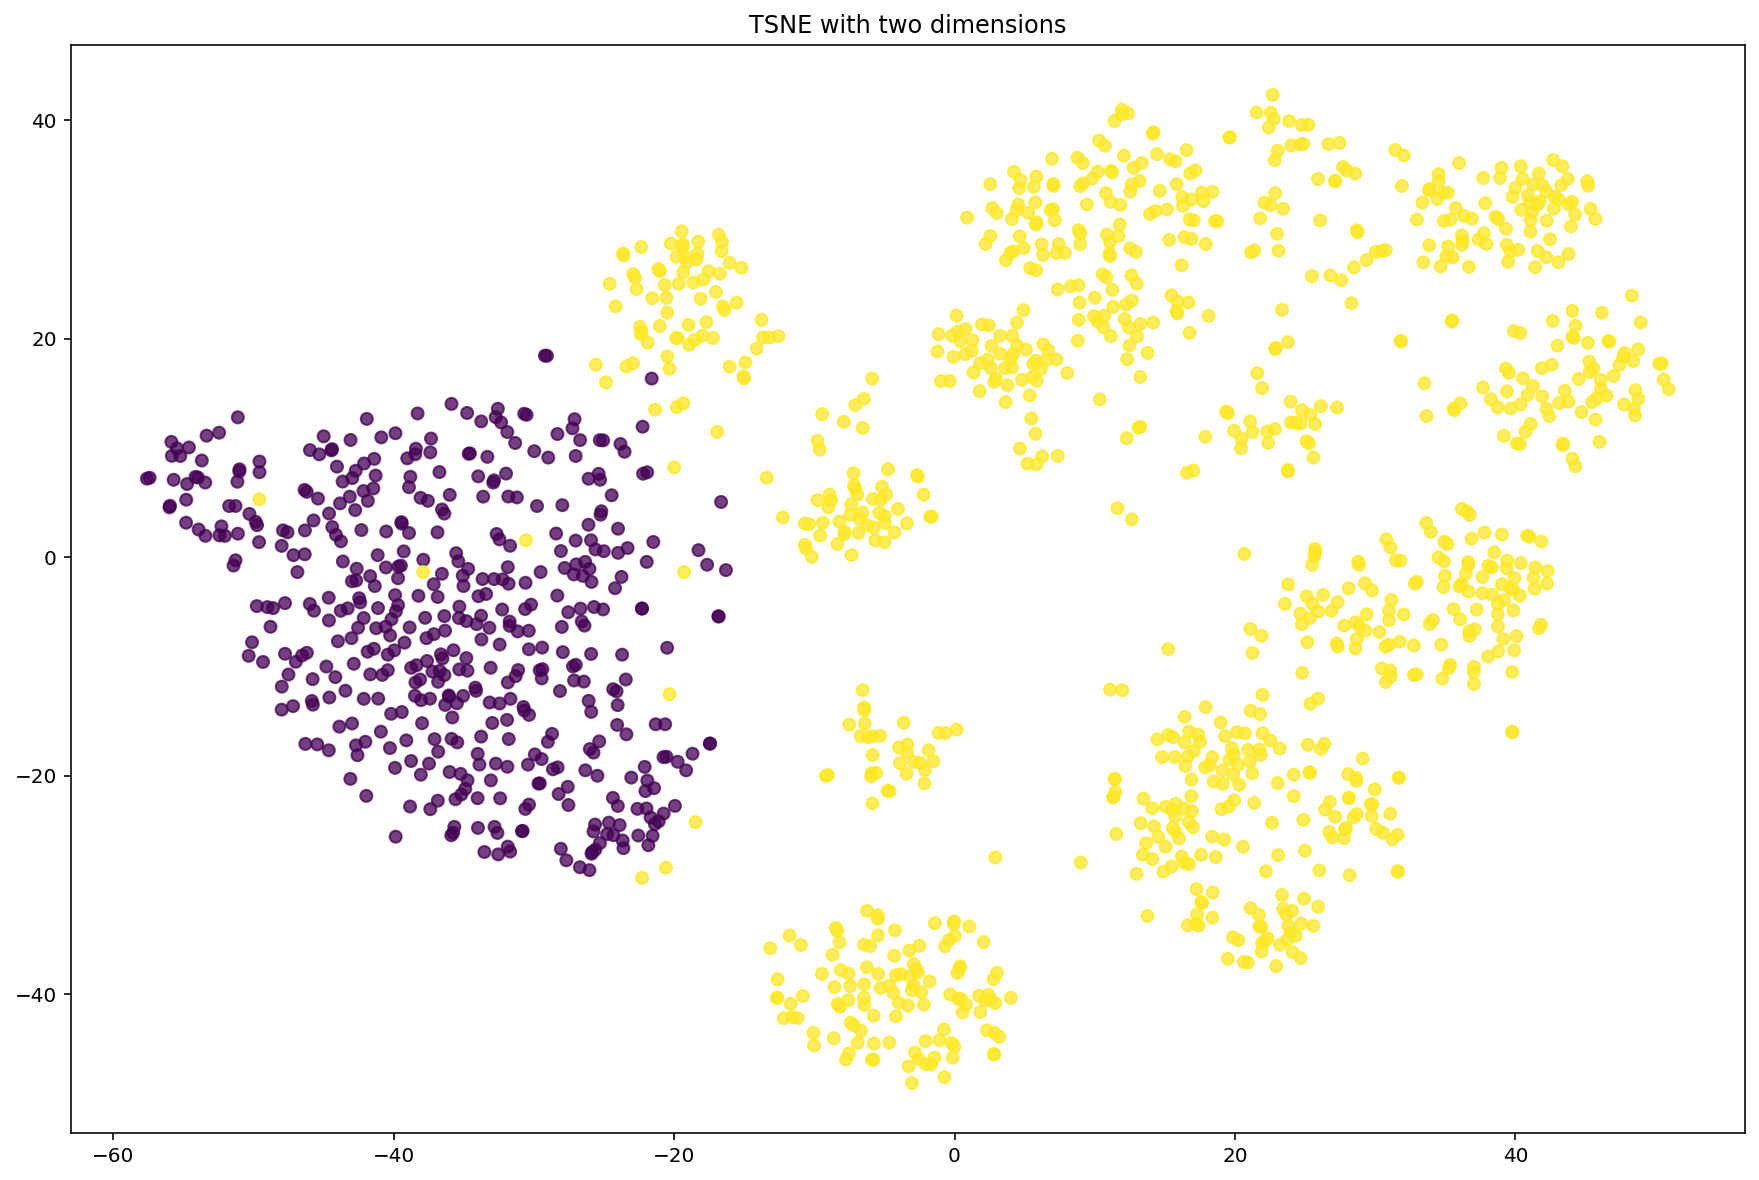

In [34]:
# Very good separation because of the strong non-linear nature of TSNE
plt.figure(figsize=(15,10))
plt.scatter(est[:,0],est[:,1],c=ldf.Dog.values, alpha=.75)
plt.title('TSNE with two dimensions');

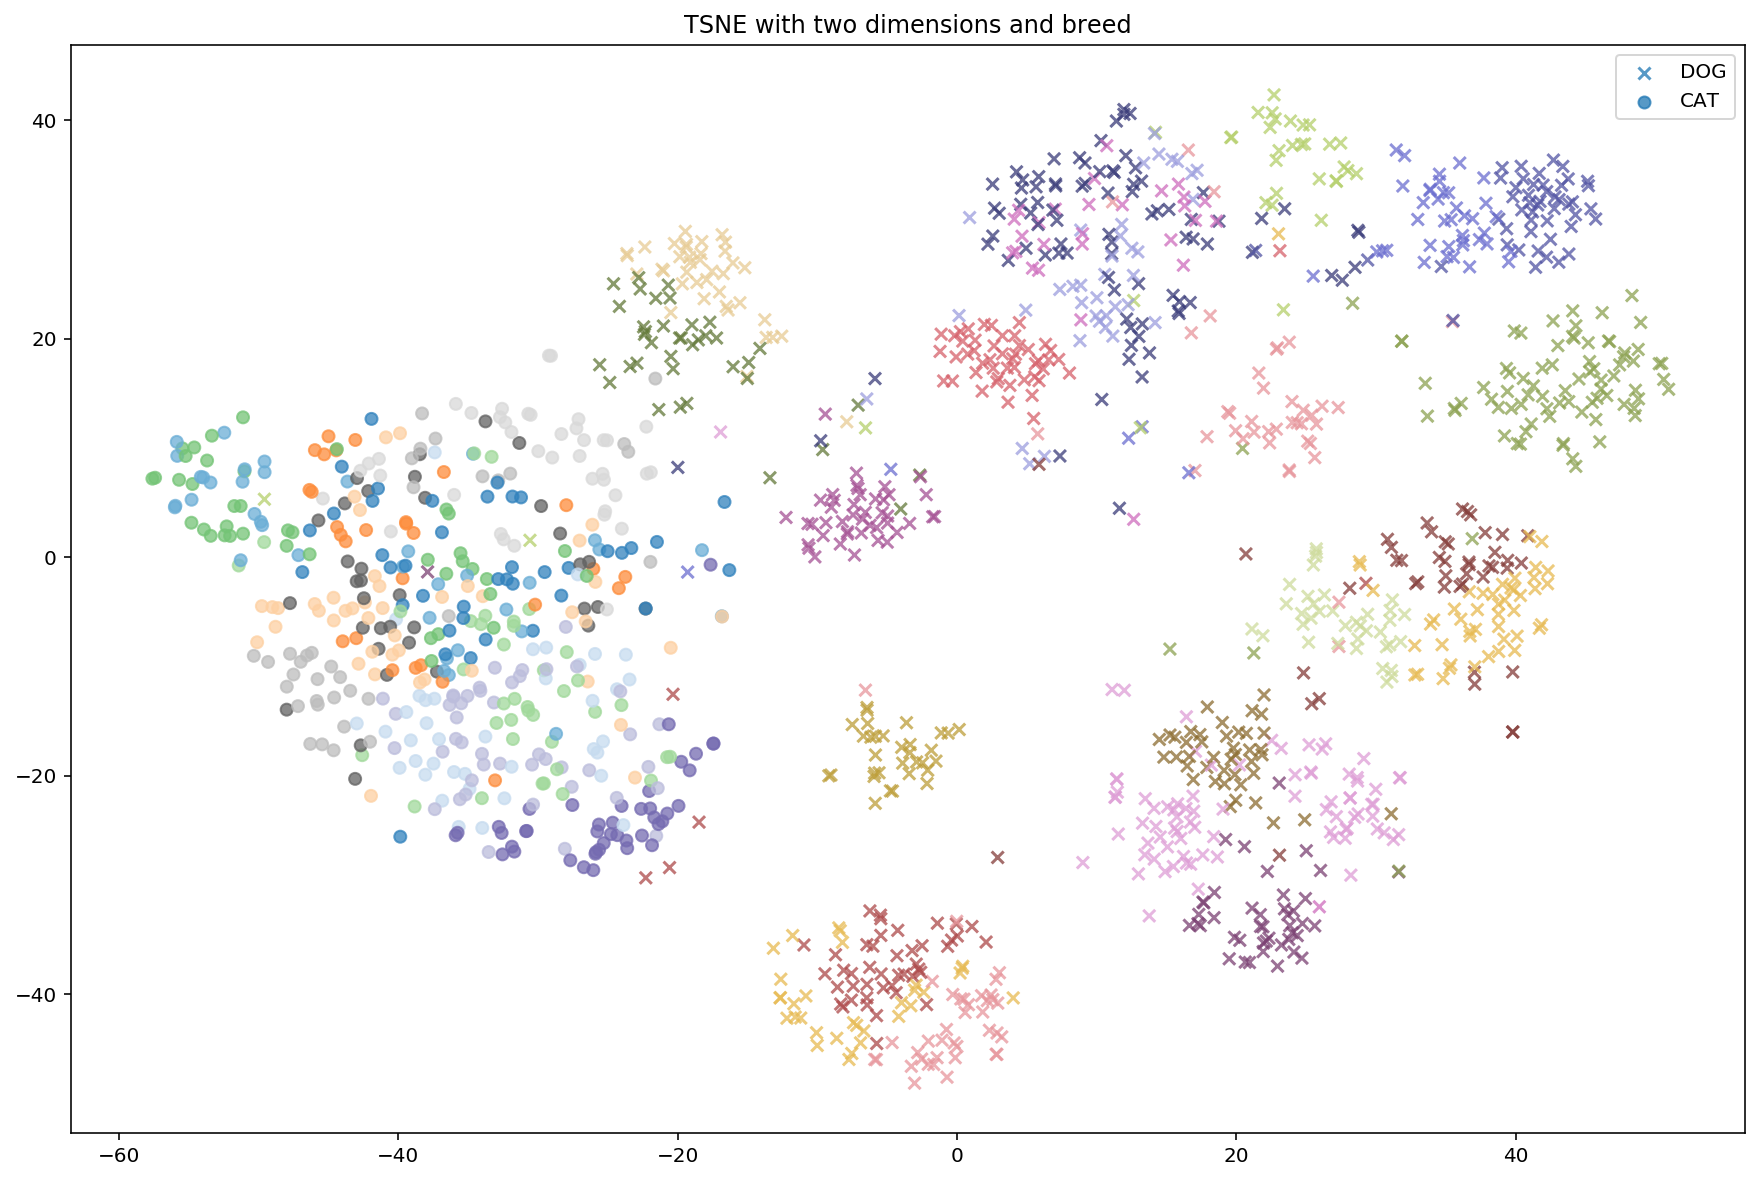

In [35]:
# IT SEEMS THAT DOG BREED IS EASIER TO DISTINGUISH THAN CAT BREED ;-)
plt.figure(figsize=(15,10))
idxs = ldf.Dog.values==1
plt.scatter(est[idxs,0],est[idxs,1],c=ldf.Breed.cat.codes[idxs], alpha=.75,cmap='tab20b', marker='x',label='DOG')
idxs = ldf.Dog.values==0
plt.scatter(est[idxs,0],est[idxs,1],c=ldf.Breed.cat.codes[idxs], alpha=.75,cmap='tab20c', marker='o',label='CAT')
plt.title('TSNE with two dimensions and breed');
plt.legend();

**IMPORTAT**: the fact that TSNE clearly finds some "patterns" it means that we're in the good direction.

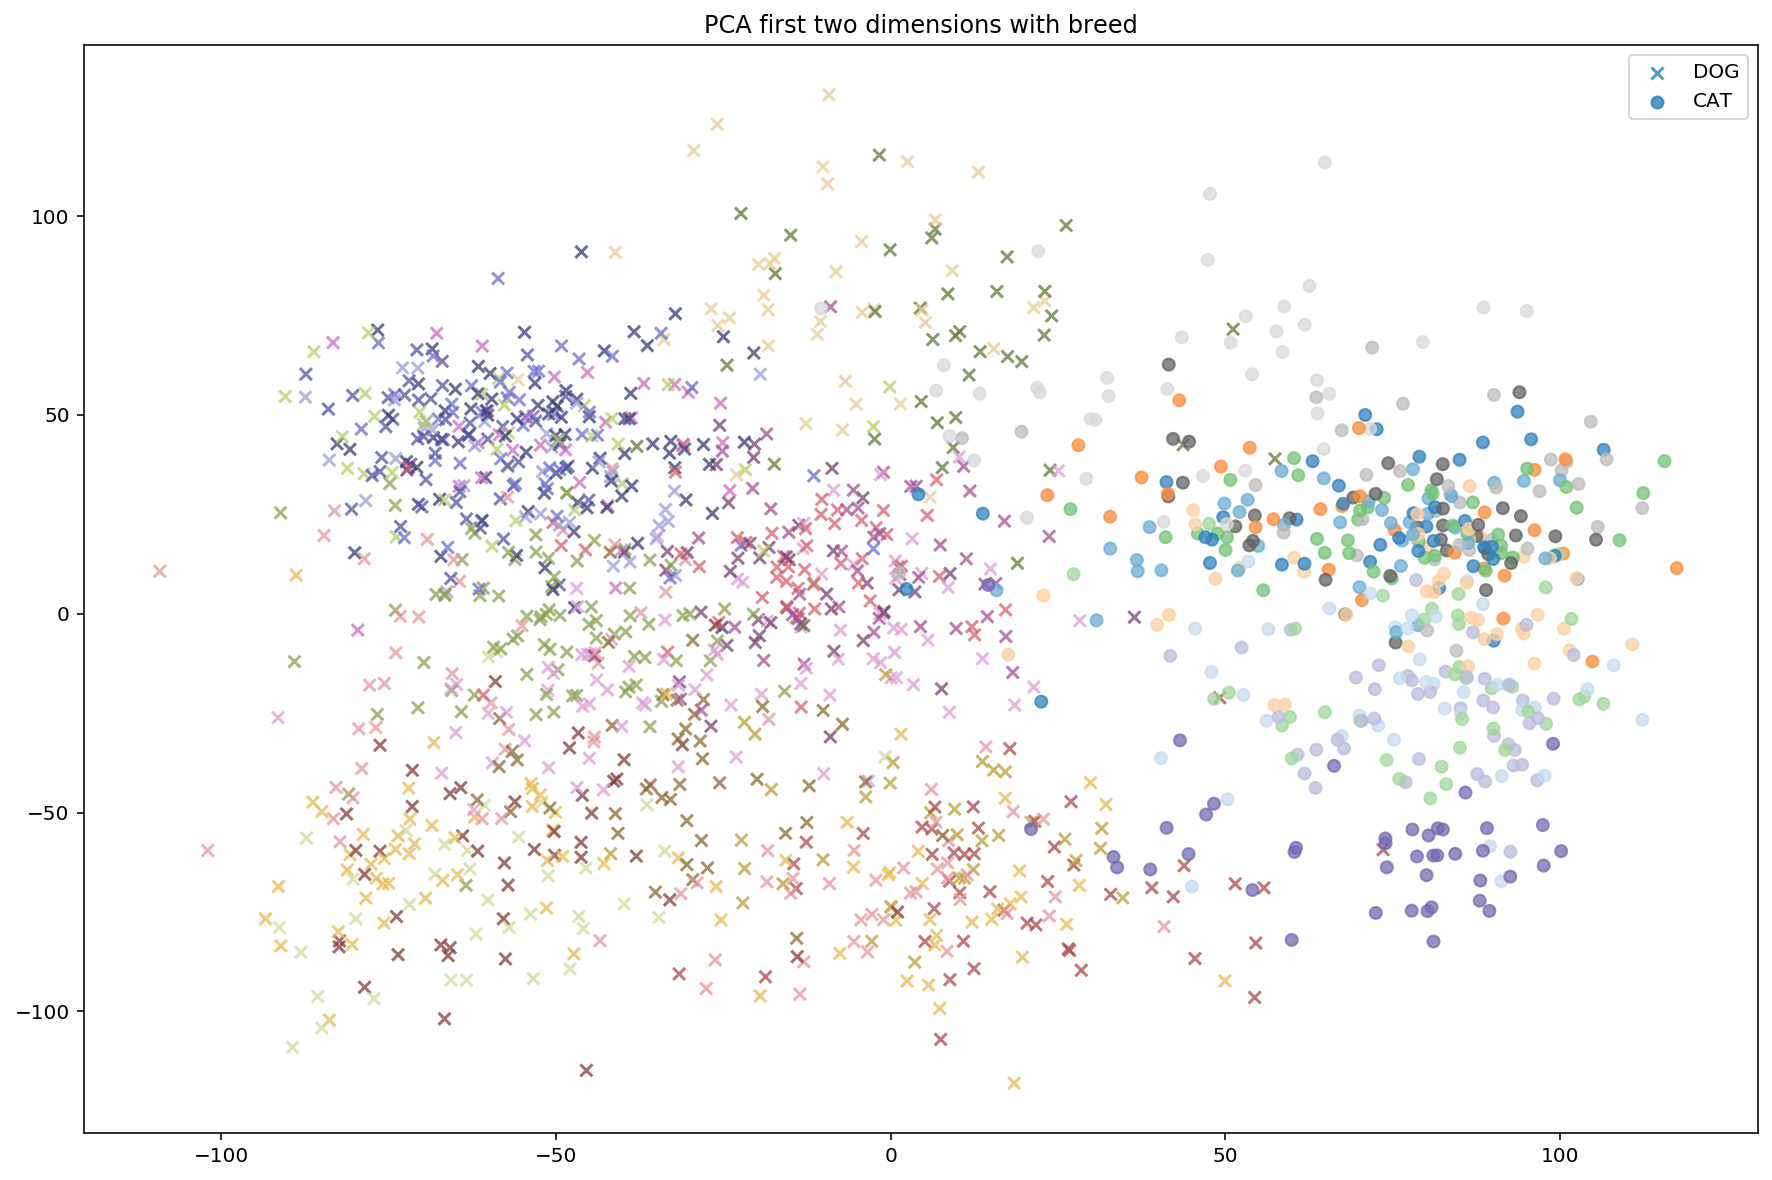

In [36]:
# Considering only the first two dimensions does not give much "separation"...
plt.figure(figsize=(15,10))
idxs = ldf.Dog.values==1
plt.scatter(esp[idxs,0],esp[idxs,1],c=ldf.Breed.cat.codes[idxs], alpha=.75,cmap='tab20b', marker='x',label='DOG')
idxs = ldf.Dog.values==0
plt.scatter(esp[idxs,0],esp[idxs,1],c=ldf.Breed.cat.codes[idxs], alpha=.75,cmap='tab20c', marker='o',label='CAT')
plt.title('PCA first two dimensions with breed');
plt.legend();

## TRY DIFFERENT CLUSTERING ALGORITHMS 

https://scikit-learn.org/stable/modules/clustering.html

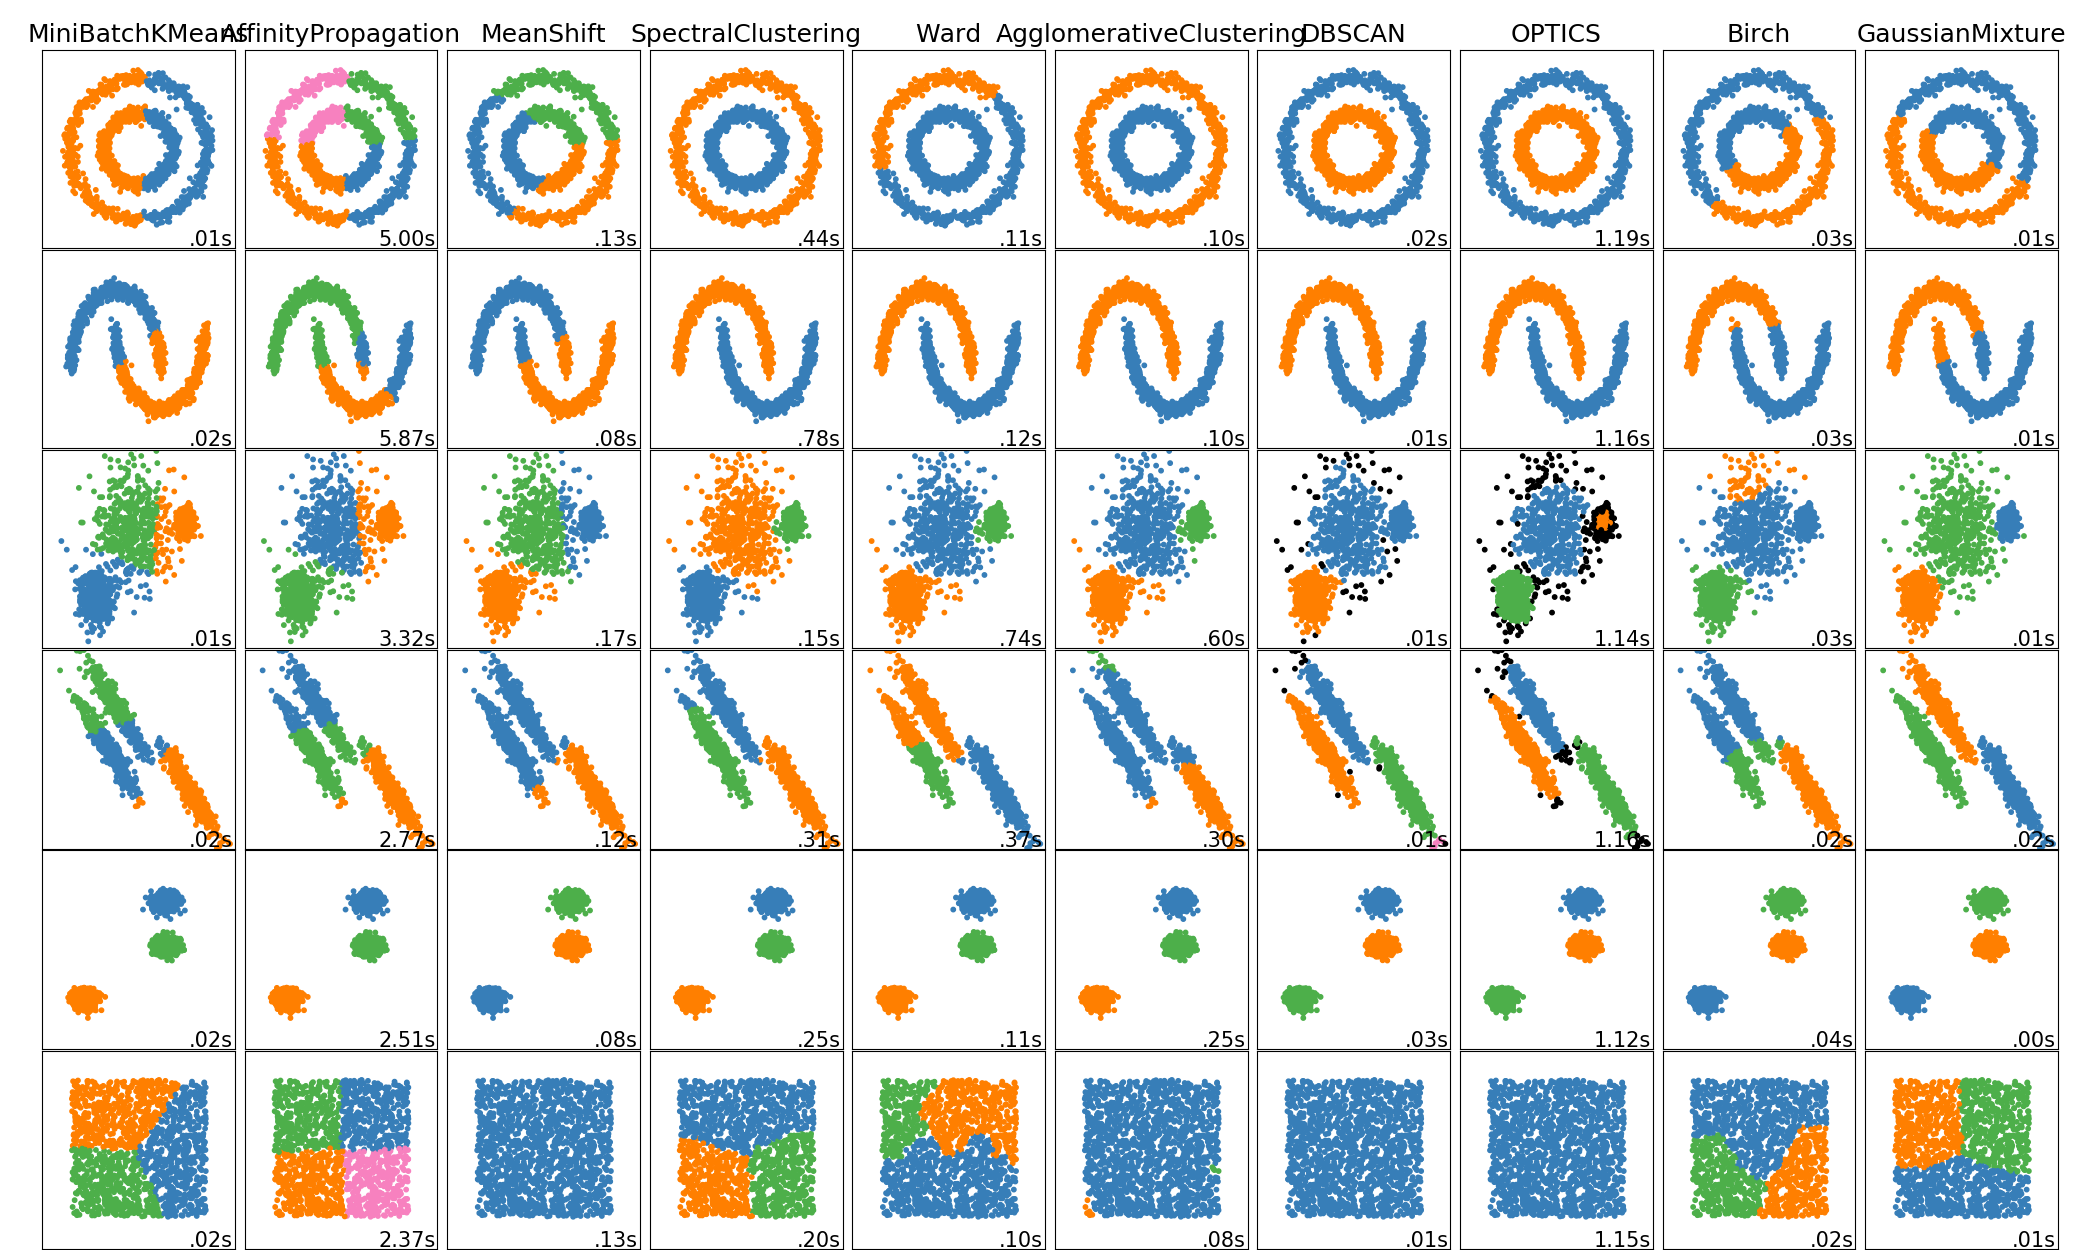

# TODO

## ADD CAR OR HOUSE IMAGES AND REDO ALL OF THIS INCREASING THE NUMBER OF CLUSTERS ACCORDINGLY (KIND OF PSEUDO LABELING)

## TRY TO FINE TUNE THE NETWORK ONLY WITH "STRONG SAMPLES" FOUND

## FINE TUNE ON REAL DOG AND CATS AND ANALIZE AGAIN THE ENCODER